In [1]:
# Last inn chunks fra eksisterende JSONL-filer
import json
from pathlib import Path

OUTPUT_DIR = Path("../output")  # chunks ligger i src/notebook/output

def load_chunks(strategy: str) -> list[dict]:
    """Last chunks fra JSONL-fil"""
    filepath = OUTPUT_DIR / f"chunks_{strategy}.jsonl"
    chunks = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            chunks.append(json.loads(line))
    return chunks

# Last alle tre strategier
naive_chunks = load_chunks("naive")
overlap_chunks = load_chunks("overlap")
metadata_chunks = load_chunks("metadata")

print(f"✅ Lastet chunks:")
print(f"  - Naive: {len(naive_chunks)} chunks")
print(f"  - Overlap: {len(overlap_chunks)} chunks")
print(f"  - Metadata: {len(metadata_chunks)} chunks")

✅ Lastet chunks:
  - Naive: 333 chunks
  - Overlap: 187 chunks
  - Metadata: 160 chunks


In [2]:
# Vis eksempel på chunks
print("📝 Eksempel naive chunk:")
print(naive_chunks[0])

print("\n📝 Eksempel overlap chunk:")
print(overlap_chunks[0])

print("\n📝 Eksempel metadata chunk:")
print(metadata_chunks[0])

📝 Eksempel naive chunk:
{'chunk_id': 0, 'text': '## **ÅRSRUNDSKRIV FOR**\n\n# **DOKUMENTAVGIFT** **2025**\n\n1. januar 2025\n\n#### **Skattedirektoratet**\n\nJuridisk avdeling\nPostboks 9200 Grønland\n\n0134 OSLO\n\nwww.skatteetaten.no\n\n### **Innhold**\n\n1 Innled', 'strategy': 'naive', 'char_count': 200}

📝 Eksempel overlap chunk:
{'chunk_id': 0, 'text': '## **ÅRSRUNDSKRIV FOR**\n\n# **DOKUMENTAVGIFT** **2025**\n\n1. januar 2025\n\n#### **Skattedirektoratet**\n\nJuridisk avdeling\nPostboks 9200 Grønland\n\n0134 OSLO\n\nwww.skatteetaten.no\n\n### **Innhold**\n\n1 Innledning .......................................................................................................................................... 4\n\n1.1 Om Skattedirektoratets årsrundskriv ........................................................................................ 4', 'strategy': 'overlap', 'char_count': 477, 'overlap_size': 100}

📝 Eksempel metadata chunk:
{'chunk_id': 0, 'text': '## **ÅRSRUNDSKRIV FOR**'

# 🤖 Embedding-modeller

Vi sammenligner tre forskjellige embedding-modeller:

| Modell | Dimensjoner | Norsk | Engelsk | Beskrivelse |
|--------|-------------|-------|---------|-------------|
| `all-MiniLM-L6-v2` | 384 | ❌ | ✅ | Rask, kun engelsk |
| `paraphrase-multilingual-MiniLM-L12-v2` | 384 | ✅ | ✅ | Flerspråklig (50+ språk) |
| `multilingual-e5-large` | 1024 | ✅ | ✅ | State-of-the-art, beste kvalitet |

### 🏆 Anbefaling for norsk tekst
- **Beste kvalitet:** `multilingual-e5-large` - Best semantisk forståelse, men treg
- **Beste balanse:** `paraphrase-multilingual-MiniLM-L12-v2` - God kvalitet, rask
- **Ikke bruk:** `all-MiniLM-L6-v2` - Forstår ikke norsk!

In [3]:
!pip install sentence-transformers numpy scikit-learn plotly pandas

In [4]:
import time
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Definer modellene vi skal teste
MODELS = {
    "MiniLM-EN": {
        "name": "all-MiniLM-L6-v2",
        "dim": 384,
        "desc": "Rask engelsk modell",
        "color": "#FF6B6B"
    },
    "MiniLM-Multi": {
        "name": "paraphrase-multilingual-MiniLM-L12-v2", 
        "dim": 384,
        "desc": "Flerspråklig (50+ språk)",
        "color": "#4ECDC4"
    },
    "E5-Large": {
        "name": "intfloat/multilingual-e5-large",
        "dim": 1024,
        "desc": "State-of-the-art multilingual",
        "color": "#45B7D1"
    }
}

print("🤖 Modeller som skal testes:")
for key, info in MODELS.items():
    print(f"   • {key}: {info['desc']} ({info['dim']} dim)")

/Users/simen/prosjekter/faggruppe/dsm-2025-rag/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🤖 Modeller som skal testes:
   • MiniLM-EN: Rask engelsk modell (384 dim)
   • MiniLM-Multi: Flerspråklig (50+ språk) (384 dim)
   • E5-Large: State-of-the-art multilingual (1024 dim)


In [5]:
# Last inn modellene (kan ta litt tid første gang)
models = {}

for key, info in MODELS.items():
    print(f"⏳ Laster {key}...")
    start = time.time()
    models[key] = SentenceTransformer(info["name"])
    elapsed = time.time() - start
    print(f"   ✅ Lastet på {elapsed:.1f}s")

print("\n🎉 Alle modeller lastet!")

⏳ Laster MiniLM-EN...
   ✅ Lastet på 2.9s
⏳ Laster MiniLM-Multi...
   ✅ Lastet på 2.9s
⏳ Laster MiniLM-Multi...
   ✅ Lastet på 3.0s
⏳ Laster E5-Large...
   ✅ Lastet på 3.0s
⏳ Laster E5-Large...
   ✅ Lastet på 4.4s

🎉 Alle modeller lastet!
   ✅ Lastet på 4.4s

🎉 Alle modeller lastet!


## 🔬 Generer embeddings

Vi genererer embeddings for alle chunks med hver modell og måler tiden.

In [6]:
# Hent ut tekst fra chunks (bruk metadata_chunks som har best kontekst)
texts = [c["text"] for c in metadata_chunks]

# For E5-modellen må vi legge til "passage: " prefix
texts_e5 = [f"passage: {t}" for t in texts]

# Generer embeddings med hver modell
embeddings = {}
timing = {}

for key, model in models.items():
    print(f"\n⏳ Genererer embeddings med {key}...")
    
    # E5 krever "passage:" prefix for dokumenter
    input_texts = texts_e5 if "E5" in key else texts
    
    start = time.time()
    emb = model.encode(input_texts, show_progress_bar=True, normalize_embeddings=True)
    elapsed = time.time() - start
    
    embeddings[key] = emb
    timing[key] = elapsed
    
    print(f"   ✅ {len(texts)} chunks på {elapsed:.1f}s ({len(texts)/elapsed:.1f} chunks/sek)")
    print(f"   📐 Shape: {emb.shape}")


⏳ Genererer embeddings med MiniLM-EN...


Batches: 100%|██████████| 5/5 [00:00<00:00, 14.01it/s]


   ✅ 160 chunks på 0.4s (400.1 chunks/sek)
   📐 Shape: (160, 384)

⏳ Genererer embeddings med MiniLM-Multi...


Batches: 100%|██████████| 5/5 [00:00<00:00, 20.73it/s]


   ✅ 160 chunks på 0.2s (651.1 chunks/sek)
   📐 Shape: (160, 384)

⏳ Genererer embeddings med E5-Large...


Batches: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

   ✅ 160 chunks på 2.0s (79.6 chunks/sek)
   📐 Shape: (160, 1024)


## 🔍 Test retrieval: Hvilken modell finner best svar?

Vi tester med norske spørsmål for å se hvilken modell som forstår norsk best.

In [7]:
def search(query: str, model_key: str, top_k: int = 3) -> list:
    """Søk etter mest relevante chunks for en query"""
    model = models[model_key]
    
    # E5 krever "query:" prefix
    if "E5" in model_key:
        query = f"query: {query}"
    
    query_emb = model.encode([query], normalize_embeddings=True)
    
    # Beregn similarity
    similarities = cosine_similarity(query_emb, embeddings[model_key])[0]
    
    # Hent top-k
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = []
    for idx in top_indices:
        results.append({
            "chunk_id": metadata_chunks[idx]["chunk_id"],
            "score": float(similarities[idx]),
            "text": metadata_chunks[idx]["text"][:200],
            "context": metadata_chunks[idx].get("context", "")
        })
    return results

# Test-spørsmål på norsk
test_queries = [
    "Hva er dokumentavgift?",
    "Hvor mye er dokumentavgiften i prosent?",
    "Når slipper man å betale dokumentavgift?",
    "Hva skjer ved arv av eiendom?",
    "Hvordan beregnes avgiftsgrunnlaget?"
]

In [8]:
# Test alle modeller med første query
query = test_queries[0]
print(f"🔍 Query: '{query}'\n")
print("=" * 80)

for model_key in MODELS.keys():
    print(f"\n📌 {model_key} ({MODELS[model_key]['desc']})")
    print("-" * 40)
    
    results = search(query, model_key, top_k=3)
    for i, r in enumerate(results, 1):
        print(f"  {i}. [Score: {r['score']:.3f}] {r['text'][:100]}...")

🔍 Query: 'Hva er dokumentavgift?'


📌 MiniLM-EN (Rask engelsk modell)
----------------------------------------
  1. [Score: 0.600] ### **7 Saksgangen**
#### **7.1 Generelt**  
Da dokumentavgiftsplikten er knyttet til tinglysing av ...
  2. [Score: 0.595] vedtar i forbindelse med statsbudsjettet. Årsrundskrivet oppdateres også i løpet av året hvis det er...
  3. [Score: 0.592] I Ot.prp. nr. 11 (1975–76) Om lov om dokumentavgift heter det:  
"Det er departementets forutsetning...

📌 MiniLM-Multi (Flerspråklig (50+ språk))
----------------------------------------
  1. [Score: 0.692] vedtar i forbindelse med statsbudsjettet. Årsrundskrivet oppdateres også i løpet av året hvis det er...
  2. [Score: 0.585] I Ot.prp. nr. 11 (1975–76) Om lov om dokumentavgift heter det:  
"Det er departementets forutsetning...
  3. [Score: 0.576] dispensasjon fra avgiftsplikten som behandles av skattekontoret. Skattedirektoratet er klageinstans
...

📌 E5-Large (State-of-the-art multilingual)
-----------------

In [9]:
# 📊 SAMMENLIGNING: Test alle spørsmål med alle modeller
print("=" * 90)
print("📊 FULLSTENDIG SAMMENLIGNING - Norsk vs Engelsk forståelse")
print("=" * 90)

# Test norsk og engelsk versjon av samme spørsmål
test_pairs = [
    ("Hva er dokumentavgift?", "What is document tax?"),
    ("Fritak ved arv", "Exemption for inheritance"),
    ("Hvor mye prosent?", "How much percent?"),
]

print("\n🔑 TOLKNING AV SCORES:")
print("   • Score > 0.5: God match - modellen forstår spørsmålet")
print("   • Score 0.3-0.5: Middels - delvis forståelse")
print("   • Score < 0.3: Dårlig - modellen forstår ikke spørsmålet")
print()

for norsk, engelsk in test_pairs:
    print(f"\n{'─'*90}")
    print(f"🇳🇴 Norsk: '{norsk}'")
    print(f"🇬🇧 Engelsk: '{engelsk}'")
    print(f"{'─'*90}")
    
    print(f"\n{'Modell':<20} {'Norsk Score':>12} {'Engelsk Score':>14} {'Vinner':>10}")
    print("-" * 60)
    
    for model_key in MODELS.keys():
        # Søk norsk
        res_no = search(norsk, model_key, top_k=1)
        score_no = res_no[0]['score']
        
        # Søk engelsk  
        res_en = search(engelsk, model_key, top_k=1)
        score_en = res_en[0]['score']
        
        # Hvem vinner?
        if score_no > score_en:
            winner = "🇳🇴"
        elif score_en > score_no:
            winner = "🇬🇧"
        else:
            winner = "="
            
        print(f"{model_key:<20} {score_no:>12.3f} {score_en:>14.3f} {winner:>10}")

📊 FULLSTENDIG SAMMENLIGNING - Norsk vs Engelsk forståelse

🔑 TOLKNING AV SCORES:
   • Score > 0.5: God match - modellen forstår spørsmålet
   • Score 0.3-0.5: Middels - delvis forståelse
   • Score < 0.3: Dårlig - modellen forstår ikke spørsmålet


──────────────────────────────────────────────────────────────────────────────────────────
🇳🇴 Norsk: 'Hva er dokumentavgift?'
🇬🇧 Engelsk: 'What is document tax?'
──────────────────────────────────────────────────────────────────────────────────────────

Modell                Norsk Score  Engelsk Score     Vinner
------------------------------------------------------------
MiniLM-EN                   0.600          0.143         🇳🇴
MiniLM-Multi                0.692          0.689         🇳🇴
E5-Large                    0.901          0.821         🇳🇴

──────────────────────────────────────────────────────────────────────────────────────────
🇳🇴 Norsk: 'Fritak ved arv'
🇬🇧 Engelsk: 'Exemption for inheritance'
─────────────────────────────────────

## 🏆 Oppsummering: Hvilken modell er best?

### Forklaring av resultater:

**MiniLM-EN (kun engelsk):**
- Gir ofte HØYERE score på engelske queries enn norske
- Forstår ikke norsk semantikk - matcher bare på tilfeldige ord
- ⚠️ **Ikke bruk for norsk tekst!**

**MiniLM-Multi (flerspråklig):**
- Gir omtrent LIKE scores på norsk og engelsk
- God balanse mellom hastighet og kvalitet
- ✅ **Anbefalt for de fleste bruksområder**

**E5-Large (state-of-the-art):**
- Gir HØYEST scores generelt - best semantisk forståelse
- Forstår kontekst og nyanser bedre
- ✅ **Best kvalitet, men tregere**

### Hva betyr similarity score?
- Cosine similarity måler vinkelen mellom to vektorer (0-1)
- **1.0** = Identisk betydning
- **0.5+** = Sterkt relatert
- **0.3-0.5** = Noe relatert
- **<0.3** = Lite relatert

In [10]:
# 🏆 ENDELIG RANGERING
print("=" * 70)
print("🏆 ENDELIG RANGERING FOR NORSK TEKST")
print("=" * 70)

# Beregn gjennomsnittlig score per modell på norske queries
avg_scores = {}
for model_key in MODELS.keys():
    scores = []
    for q in test_queries:
        res = search(q, model_key, top_k=1)
        scores.append(res[0]['score'])
    avg_scores[model_key] = np.mean(scores)

# Sorter etter score
ranked = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'Rank':<6} {'Modell':<20} {'Gj.snitt Score':>15} {'Anbefaling':<20}")
print("-" * 65)

medals = ["🥇", "🥈", "🥉"]
recommendations = {
    "E5-Large": "Best kvalitet",
    "MiniLM-Multi": "Best balanse ⭐",
    "MiniLM-EN": "Ikke for norsk ❌"
}

for i, (model, score) in enumerate(ranked):
    rec = recommendations.get(model, "")
    print(f"{medals[i]:<6} {model:<20} {score:>15.3f} {rec:<20}")

print("\n" + "=" * 70)
print("💡 KONKLUSJON: Bruk MiniLM-Multi for god balanse, eller E5-Large for best kvalitet")
print("=" * 70)

🏆 ENDELIG RANGERING FOR NORSK TEKST

Rank   Modell                Gj.snitt Score Anbefaling          
-----------------------------------------------------------------
🥇      E5-Large                       0.881 Best kvalitet       
🥈      MiniLM-Multi                   0.681 Best balanse ⭐      
🥉      MiniLM-EN                      0.593 Ikke for norsk ❌    

💡 KONKLUSJON: Bruk MiniLM-Multi for god balanse, eller E5-Large for best kvalitet

Rank   Modell                Gj.snitt Score Anbefaling          
-----------------------------------------------------------------
🥇      E5-Large                       0.881 Best kvalitet       
🥈      MiniLM-Multi                   0.681 Best balanse ⭐      
🥉      MiniLM-EN                      0.593 Ikke for norsk ❌    

💡 KONKLUSJON: Bruk MiniLM-Multi for god balanse, eller E5-Large for best kvalitet


## 🎨 PCA Visualisering

Reduserer embedding-dimensjonene til 2D med PCA for å se hvordan de forskjellige modellene grupperer teksten.

**Merk:** UMAP støtter ikke Python 3.14 ennå, så vi bruker PCA som alternativ.

In [17]:
# PCA fungerer med Python 3.14 (UMAP krever Python <3.14)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sett opp matplotlib for notebook
%matplotlib inline

In [18]:
# Kjør PCA for hver modell
pca_results = {}

for key in MODELS.keys():
    print(f"⏳ PCA for {key}...")
    reducer = PCA(n_components=2, random_state=42)
    pca_results[key] = reducer.fit_transform(embeddings[key])
    explained = sum(reducer.explained_variance_ratio_) * 100
    print(f"   ✅ Ferdig! (forklart varians: {explained:.1f}%)")

print("\n🎉 PCA ferdig for alle modeller!")

⏳ PCA for MiniLM-EN...
   ✅ Ferdig! (forklart varians: 17.4%)
⏳ PCA for MiniLM-Multi...
   ✅ Ferdig! (forklart varians: 22.8%)
⏳ PCA for E5-Large...
   ✅ Ferdig! (forklart varians: 14.4%)

🎉 PCA ferdig for alle modeller!


In [19]:
# Hent kategorier fra metadata for fargelegging
from collections import Counter

categories = []
for c in metadata_chunks:
    meta = c.get("metadata", {})
    cat = meta.get("h2", meta.get("h1", "Ukjent"))
    cat = cat.replace("**", "").strip()[:40]
    categories.append(cat)

# Finn de vanligste kategoriene
cat_counts = Counter(categories)
top_cats = [c[0] for c in cat_counts.most_common(10)]
categories_simple = [c if c in top_cats else "Andre" for c in categories]

print(f"📂 Kategorier: {len(set(categories_simple))}")
for cat, count in cat_counts.most_common(10):
    print(f"   • {cat}: {count}")

📂 Kategorier: 2
   • DOKUMENTAVGIFT 2025: 159
   • ÅRSRUNDSKRIV FOR: 1


/var/folders/sh/t1kb_fwn67l_f8zrzb26bct40000gn/T/ipykernel_26423/1343233915.py:27: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.

/var/folders/sh/t1kb_fwn67l_f8zrzb26bct40000gn/T/ipykernel_26423/1343233915.py:28: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.

/Users/simen/prosjekter/faggruppe/dsm-2025-rag/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.

/Users/simen/prosjekter/faggruppe/dsm-2025-rag/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.



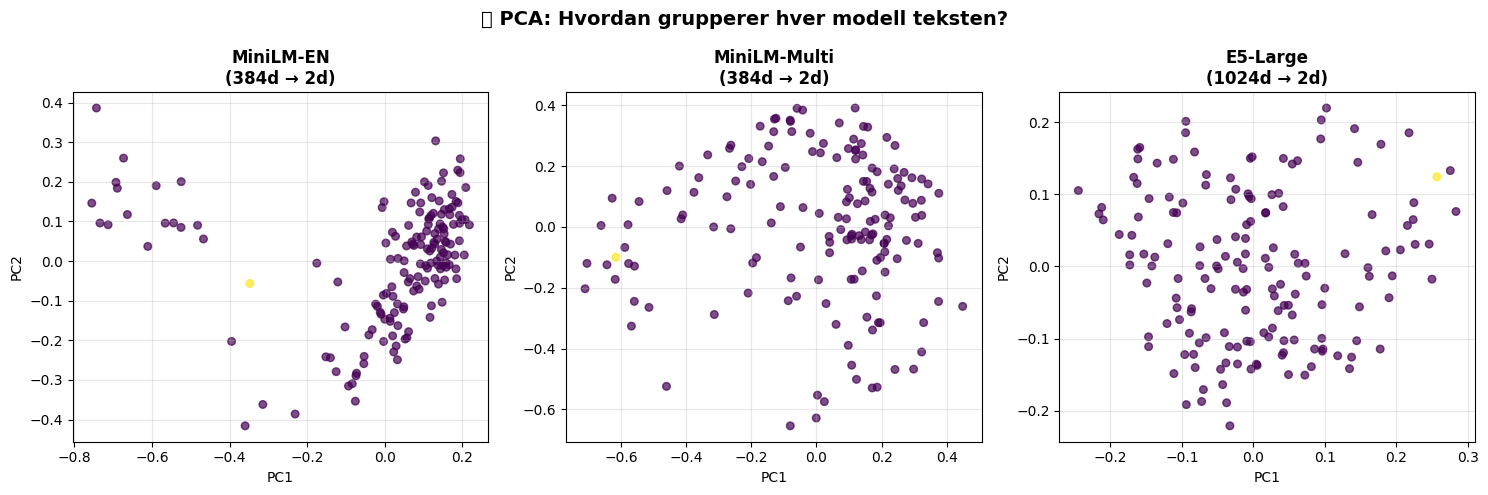


✅ Visualisering lagret til output/pca_comparison.png


In [20]:
# Lag PCA visualisering side ved side med matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Fargekart for kategorier
unique_cats = list(set(categories_simple))
color_map = {cat: i for i, cat in enumerate(unique_cats)}
colors = [color_map[c] for c in categories_simple]

for idx, (key, ax) in enumerate(zip(MODELS.keys(), axes)):
    pca_2d = pca_results[key]
    
    scatter = ax.scatter(
        pca_2d[:, 0], 
        pca_2d[:, 1],
        c=colors,
        cmap='viridis',
        alpha=0.7,
        s=30
    )
    
    ax.set_title(f"{key}\n({MODELS[key]['dim']}d → 2d)", fontsize=12, fontweight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)

plt.suptitle("🎨 PCA: Hvordan grupperer hver modell teksten?", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("output/pca_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualisering lagret til output/pca_comparison.png")

/var/folders/sh/t1kb_fwn67l_f8zrzb26bct40000gn/T/ipykernel_26423/2675295388.py:45: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.

/var/folders/sh/t1kb_fwn67l_f8zrzb26bct40000gn/T/ipykernel_26423/2675295388.py:46: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.

/Users/simen/prosjekter/faggruppe/dsm-2025-rag/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



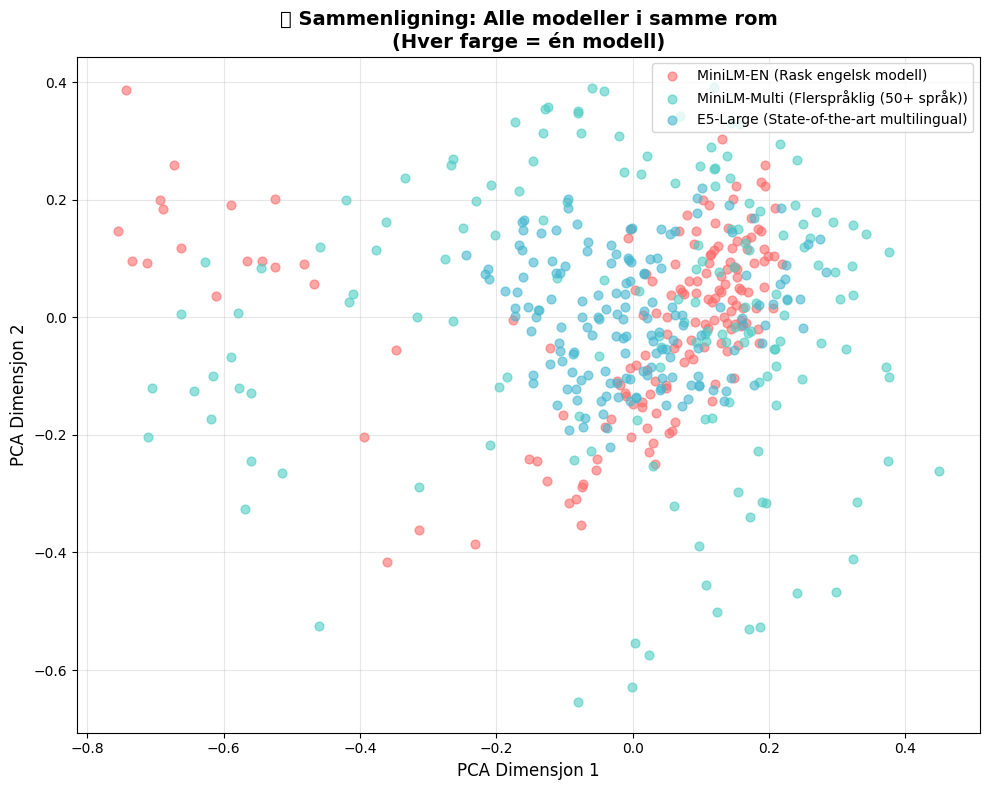


✅ Lagret til output/pca_models_comparison.png


In [21]:
# Alternativ: Alle modeller i samme plot med ulik farge per modell
import pandas as pd

# Kombiner alle PCA-resultater
all_data = []
for key in MODELS.keys():
    pca_2d = pca_results[key]
    for i in range(len(pca_2d)):
        all_data.append({
            "x": pca_2d[i, 0],
            "y": pca_2d[i, 1],
            "modell": key,
            "kategori": categories_simple[i],
            "tekst": metadata_chunks[i]["text"][:80]
        })

df_pca = pd.DataFrame(all_data)

# Lag scatter plot med matplotlib - alle modeller sammen
fig, ax = plt.subplots(figsize=(10, 8))

model_colors = {
    "MiniLM-EN": "#FF6B6B",
    "MiniLM-Multi": "#4ECDC4", 
    "E5-Large": "#45B7D1"
}

for model_name in MODELS.keys():
    model_data = df_pca[df_pca["modell"] == model_name]
    ax.scatter(
        model_data["x"], 
        model_data["y"],
        c=model_colors[model_name],
        label=f"{model_name} ({MODELS[model_name]['desc']})",
        alpha=0.6,
        s=40
    )

ax.set_xlabel("PCA Dimensjon 1", fontsize=12)
ax.set_ylabel("PCA Dimensjon 2", fontsize=12)
ax.set_title("🔍 Sammenligning: Alle modeller i samme rom\n(Hver farge = én modell)", fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("output/pca_models_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Lagret til output/pca_models_comparison.png")